# Job characteristics estimation
Here, based on the post-processed logs from the previous Jupyter notebook, single job characteristics such as waiting times and job duration, as well as CPU and memory resources are estimated. These will be statistically analysed in follow-up Jupyter notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read cleaned-up job logs

In [2]:
job_logs = pd.read_parquet('job_logs.parquet')

In [3]:
job_logs

,Identifier,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
0,50f38293dabf53e9,clbigmem,RUN,45.40,10000.86,560223.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
1,1cadd9af115874fc,clbigmem,RUN,66.43,1461501.36,181504.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
2,84b513a49a615a33,clbigmem,RUN,44.20,2973694.55,93235.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
3,817f139219e72642,clbigmem,RUN,2.01,1166604.28,36574.0,3.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
4,fc3ffa2fca1e77be,clbigmem,RUN,30.28,138055.86,4353.0,1.0,2020-02-06 19:53:11+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...,...
2878186,1a80b42d577afbfb,clmedium,QUE,0.00,0.00,0.0,8.0,2020-04-07 09:54:04+02:00,2020-03-03 11:32:54+01:00
2878187,d265ff487b48e5fc,clmedium,RUN,NaN,NaN,NaN,1.0,2020-04-07 09:54:04+02:00,2020-03-03 11:32:54+01:00
2878188,308f7cb964beb126,clmedium,RUN,NaN,NaN,NaN,1.0,2020-04-07 09:54:04+02:00,2020-03-03 11:32:54+01:00
2878189,0b37050713eca404,clmedium,RUN,NaN,NaN,NaN,1.0,2020-04-07 09:54:04+02:00,2020-03-03 11:32:54+01:00


## Drop incompletely sampled jobs
As que and run times, as well as CPU and memory resources cannot be accurately estimated for those jobs that already existed at the beginning and at the termination of a log cycle. This operation reduces the total job number close to the beginning and end of a log cycle, which should be kept in mind, and might be treated differently, especially for time series analyses.

In [4]:
original_job_log_length = len(job_logs)

In [5]:
drop_these = job_logs.set_index('Time').loc[
    job_logs.groupby(['Cycle'])['Time'].min().to_list()
]['Identifier'].to_list()

In [6]:
drop_these = drop_these + job_logs.set_index('Time').loc[
    job_logs.groupby(['Cycle'])['Time'].max().to_list()
]['Identifier'].to_list()

In [7]:
job_logs = job_logs.set_index("Identifier").drop(index=drop_these).reset_index()

In [8]:
100*len(job_logs)/original_job_log_length

91.2225769589301

## Drop multi-queue jobs

Check if jobs are only assigned to a single queue, otherwise the estimates that are calculated in the following won't be accurate. One could also remove only the job log entries for the first batch class the corresponding job was submitted to.

In [13]:
unique_queue_entries = job_logs.groupby("Identifier")["Queue"].nunique()

In [14]:
drop_these_identifiers = unique_queue_entries.index[unique_queue_entries > 1]

In [16]:
job_logs.set_index("Identifier").loc[drop_these_identifiers[0]].sort_values("Time")

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
578e6527f97828f5,clbigmem,QUE,0.00000,0.00,0.0,4.0,2020-04-03 10:29:50+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clbigmem,QUE,0.00000,0.00,0.0,4.0,2020-04-03 10:39:57+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 10:50:06+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 11:00:13+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 11:10:30+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 11:20:37+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 11:30:45+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 11:40:53+02:00,2020-03-03 11:32:54+01:00
578e6527f97828f5,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-04-03 11:51:01+02:00,2020-03-03 11:32:54+01:00


In [17]:
job_logs = job_logs.set_index("Identifier").drop(index=drop_these_identifiers).reset_index()

## Post-processing of job states

To simplify the accurate calculation of estimates for job waiting and run times (from a practical user perspective), job state discontinuities should be removed from the job log entries.

In [18]:
grouped = job_logs.groupby('STT')

In [19]:
100*grouped.count()['Time']/len(job_logs)

STT
EXT     0.040584
HLD     0.111654
POR     0.014633
PRR     0.008536
QUE    56.584208
RUN    43.116995
STG     0.009565
WAT     0.113826
Name: Time, dtype: float64

### `EXT` status
About 0.6% of the jobs have exit status records. They might appear after a job's `RUN` period. There are no CPU/memory resource and elapse time records associated with these entries, so they will simply be dropped.

In [20]:
these_identifiers = job_logs[job_logs['STT']=='EXT']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.6245933636955108

In [21]:
# Example:
job_logs.set_index('Identifier').loc[these_identifiers[11]].sort_values("Time")

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
7f18a64a9544028f,clmedium,RUN,2.25,1926.07,64.0,1.0,2020-02-08 12:38:25+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,21995.00,708.0,1.0,2020-02-08 12:49:09+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,42002.19,1350.0,1.0,2020-02-08 12:59:49+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,62970.65,1992.0,1.0,2020-02-08 13:10:32+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,6.89,82924.17,2629.0,1.0,2020-02-08 13:21:09+01:00,2020-02-06 19:52:28+01:00
...,...,...,...,...,...,...,...,...
7f18a64a9544028f,clmedium,RUN,149.72,340863.56,39224.0,1.0,2020-02-08 23:31:04+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,149.46,360576.21,39845.0,1.0,2020-02-08 23:41:25+01:00,2020-02-06 19:52:28+01:00
7f18a64a9544028f,clmedium,RUN,149.37,379114.27,40464.0,1.0,2020-02-08 23:51:45+01:00,2020-02-06 19:52:28+01:00


### `HLD` status
About 0.2% of the jobs have hold status records. Should these periods be added to a job's waiting time? Should these job log entries simply be removed? Should the whole jobs be removed, as they are not part of regular Linux cluster operation periods? Should the full time periods with non-regular Linux cluster operation be removed?

In [22]:
these_identifiers = job_logs[job_logs['STT']=='HLD']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.18054651919323358

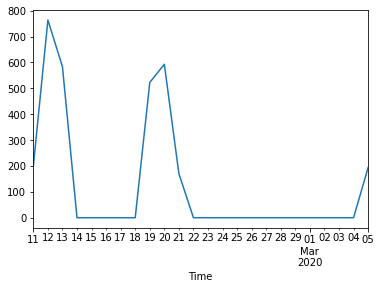

In [23]:
job_logs[job_logs['STT']=='HLD'].set_index('Time').resample('1D').sum()['Jobs'].plot()

In [24]:
# Example
job_logs.set_index('Identifier').loc[these_identifiers[2]]

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 12:40:21+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 12:51:15+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:02:07+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:12:57+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:23:51+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:34:44+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:45:38+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 13:56:31+01:00,2020-02-06 19:52:28+01:00
4993b9f181ffc499,clexpres,HLD,0.00000,0.0,0.0,1.0,2020-02-11 14:07:24+01:00,2020-02-06 19:52:28+01:00


### `POR` status
About 0.6% of the jobs have post-running status records. There are remaining memory and CPU resource information, as well as elapse time records available here. The elapse time record might be used to estimate the job duration, we therefore simplify the dataset by assigning a `RUN` state to these job log entries.

In [25]:
these_identifiers = job_logs[job_logs['STT']=='POR']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.6245933636955108

In [26]:
job_logs.set_index('Identifier').loc[these_identifiers[1]]

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:12:25+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:23:03+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:33:42+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:44:18+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 01:54:52+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:05:29+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:16:07+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:26:45+01:00,2020-02-06 19:52:28+01:00
e72bfd0bae1058bd,clmedium,QUE,0.00000,0.00,0.0,4.0,2020-02-07 02:37:24+01:00,2020-02-06 19:52:28+01:00


### `PRR` status
About 0.4% of the jobs have pre-running status records. This status appears at the transition from `QUE` to `RUN` state. No elapse time or CPU/memory resource information are available. This discontinuity should be taken into account for estimating the waiting time characteristics. To remove the discontinuity, we will manually assign the `QUE` status for these entries.

In [27]:
these_identifiers = job_logs[job_logs['STT']=='PRR']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.36109303838646717

In [28]:
# Example
job_logs.set_index('Identifier').loc[these_identifiers[17]]

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
d1a4c45aace58353,clbigmem,PRR,0.00,0.00,0.0,1.0,2020-02-14 21:11:57+01:00,2020-02-06 19:52:28+01:00
d1a4c45aace58353,clbigmem,RUN,8.39,20714.85,651.0,1.0,2020-02-14 21:22:49+01:00,2020-02-06 19:52:28+01:00
d1a4c45aace58353,clbigmem,RUN,8.46,40828.78,1301.0,1.0,2020-02-14 21:33:39+01:00,2020-02-06 19:52:28+01:00
d1a4c45aace58353,clbigmem,RUN,8.53,61868.35,1951.0,1.0,2020-02-14 21:44:29+01:00,2020-02-06 19:52:28+01:00
d1a4c45aace58353,clbigmem,RUN,8.60,81982.30,2599.0,1.0,2020-02-14 21:55:17+01:00,2020-02-06 19:52:28+01:00
d1a4c45aace58353,clbigmem,RUN,8.67,103053.70,3249.0,1.0,2020-02-14 22:06:07+01:00,2020-02-06 19:52:28+01:00
d1a4c45aace58353,clbigmem,RUN,8.72,124093.21,3893.0,1.0,2020-02-14 22:16:51+01:00,2020-02-06 19:52:28+01:00


In [29]:
# Example
with pd.option_context('display.max_rows', None):
    display(job_logs.set_index('Identifier').loc[these_identifiers[221]])

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:08:39+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:18:40+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:28:41+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:38:42+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:48:43+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 06:58:43+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 07:08:44+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 07:18:45+02:00,2020-03-03 11:32:54+01:00
8a29b474b7002d06,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-05 07:28:46+02:00,2020-03-03 11:32:54+01:00


### `STG` status
About 0.4% of the jobs have staging status records. This status appears between the `QUE` and `RUN` state. No elapse time or CPU/memory resource information are available. The discontinuity should be taken into account for estimating the waiting time, though. For simplicity, we will manually assign the `QUE` state for these entries.

In [30]:
these_identifiers = job_logs[job_logs['STT']=='STG']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.4082628497072219

In [31]:
# Example
job_logs.set_index('Identifier').loc[these_identifiers[250]]

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 21:55:25+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:05:26+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:15:27+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:25:28+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:35:29+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:45:30+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 22:55:31+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 23:05:32+02:00,2020-03-03 11:32:54+01:00
57fe9649cf6ede24,clmedium,QUE,0.00,0.00,0.0,4.0,2020-04-03 23:15:33+02:00,2020-03-03 11:32:54+01:00


### `WAT` status
About 0.7% of the jobs have waiting status records. These occur before the `QUE` job states. Should this be added to the que time estimate?

In [32]:
these_identifiers = job_logs[job_logs['STT']=='WAT']['Identifier'].unique()
100*these_identifiers.size/job_logs['Identifier'].unique().size

0.07482108002602472

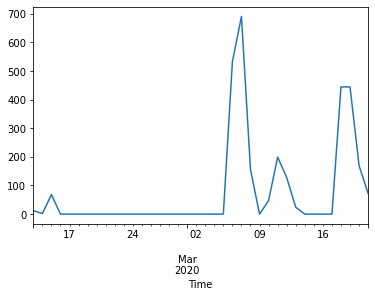

In [33]:
job_logs[job_logs['STT']=='WAT'].set_index('Time').resample('1D').sum()['Jobs'].plot()

In [34]:
job_logs.set_index('Identifier').loc[these_identifiers[1]]

,Queue,STT,Memory,CPU,Elapse,Jobs,Time,Cycle
Identifier,,,,,,,,
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:22:36+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:33:33+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:44:32+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 13:55:34+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 14:06:35+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 14:17:42+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,WAT,0.00000,0.00,0.0,1.0,2020-02-13 14:28:38+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,RUN,1.01426,190.20,557.0,1.0,2020-02-13 14:39:35+01:00,2020-02-06 19:52:28+01:00
0c270e0e2f5749a2,clfo2,RUN,2.77000,481.10,1225.0,1.0,2020-02-13 14:50:42+01:00,2020-02-06 19:52:28+01:00


### Apply the post-processing

In [35]:
job_logs.replace(to_replace='PRR', value='QUE', inplace=True)

In [36]:
job_logs.replace(to_replace='STG', value='QUE', inplace=True)

In [37]:
job_logs.replace(to_replace='POR', value='RUN', inplace=True)

In [38]:
drop_these = job_logs['STT']=='EXT'
job_logs.drop(job_logs.index[drop_these], inplace=True)

The goal would be that only continuous `QUE` and `RUN` states are left here.

In [39]:
grouped = job_logs.groupby('STT')
grouped.count()

,Identifier,Queue,Memory,CPU,Elapse,Jobs,Time,Cycle
STT,,,,,,,,
HLD,2930,2930,2930,2930,2930,2930,2930,2930
QUE,1485351,1485351,1484809,1484809,1484809,1485351,1485351,1485351
RUN,1131855,1131855,1123066,1123066,1123066,1131855,1131855,1131855
WAT,2987,2987,2987,2987,2987,2987,2987,2987


## Job characteristics estimation

### Queue

In [40]:
job_queue = job_logs.groupby('Identifier')['Queue'].unique()

### Submission date
Note, currently the `QUE` status is not always the first, i.e. the submission job status.

In [41]:
grouped = job_logs[job_logs['STT']=='QUE'].groupby('Identifier')
job_submission = grouped['Time'].min()

### Waiting time
Partly bias corrected for the sampling error at the end of each jobs' time series by using the elapse time record of the first job entry with a `RUN` state. The sampling bias at the beginning of the time series is left uncorrected, actual waiting times are thus underestimated.

The sampling bias as estimated from the transition of the job from `QUE` into `RUN` state is on average 5:17 minutes, i.e. about half of the sampling interval. This value might be taken as error estimate for the waiting times calculated here. (Note, the magnitude of the error has consequences for the interpretability of waiting times for very shortly waiting jobs.)

In [42]:
grouped1 = job_logs[job_logs['STT']=='QUE'].groupby('Identifier')
job_waited = grouped1['Time'].max()-grouped1['Time'].min() # Biased estimate.

In [43]:
grouped2 = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
sampling_bias = grouped2['Time'].min()-grouped1['Time'].max()-pd.to_timedelta(grouped2['Elapse'].min(), unit='s')

0 days 00:05:16.767649


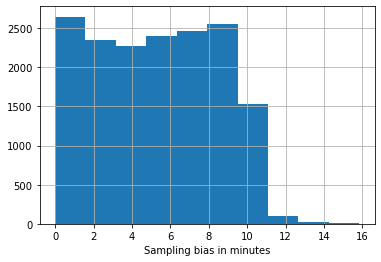

In [44]:
(sampling_bias.dt.total_seconds()/60).hist()
plt.xlabel('Sampling bias in minutes')
print(sampling_bias.mean())

In [45]:
sampling_bias[sampling_bias.isna()] = pd.to_timedelta(0.0, unit='s') # Fill NaT values with zero.
job_waited += sampling_bias
job_waited = job_waited.dt.total_seconds()/60 # in minutes

### Starting date
We don't simply take the date of the first `RUN` state of each job here, but also apply a sampling bias correction based on the elapse time recorded for the job's first `RUN` state.

In [46]:
grouped = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
sampling_bias = pd.to_timedelta(grouped['Elapse'].min(), unit='s')
job_start = grouped['Time'].min()-sampling_bias

0 days 00:04:01.274405


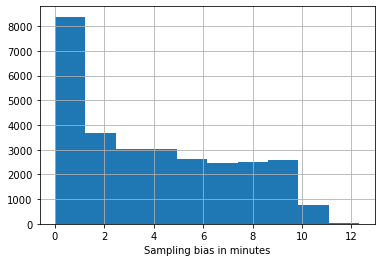

In [47]:
(sampling_bias.dt.total_seconds()/60).hist()
plt.xlabel('Sampling bias in minutes')
print(sampling_bias.mean())

### Duration
Note, there is an underestimation, i.e. a sampling bias, for the job duration estimate as well.

In [48]:
grouped = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
job_duration = grouped['Elapse'].max()/60 # in minutes

### CPU and memory resources

In [49]:
job_logs['CPU_occ'] = job_logs['CPU']/job_logs['Elapse']
grouped = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
# Calculating a mean would underestimate utilized CPUs due to the job "warm up" time!
job_cpu = grouped['CPU_occ'].max()

In [50]:
grouped = job_logs[job_logs['STT']=='RUN'].groupby('Identifier')
job_memory = grouped['Memory'].max()

### Nodes per job

In [51]:
job_nodes = job_logs.groupby('Identifier')['Jobs'].mean()

## Store on disk

In [52]:
derived_data = {'Queue': job_queue,
                'Submission': job_submission,
                'Nodes': job_nodes,
                'Waited': job_waited,
                'Start': job_start,
                'Duration': job_duration,
                'CPUs': job_cpu,
                'Memory': job_memory}

In [53]:
job_chars = pd.DataFrame(data=derived_data)

In [54]:
job_chars.to_parquet('job_chars.parquet', compression='gzip')

In [55]:
job_chars

,Queue,Submission,Nodes,Waited,Start,Duration,CPUs,Memory
000030ecd19c9c04,[feque],2020-02-18 11:14:38+01:00,1.0,29.916667,2020-02-18 11:44:33+01:00,1.450000,0.168851,0.31349
00027e89035bec8d,[clmedium],2020-03-25 21:22:02+01:00,1.0,38.783333,2020-03-25 22:00:49+01:00,1.283333,21.721169,131.76000
0003a37a7a8562f1,[clexpres],2020-03-06 11:52:11+01:00,1.0,70.450000,NaT,NaN,NaN,NaN
00040700e386e4c9,[clfo2],NaT,8.0,NaN,2020-02-07 08:27:49+01:00,33.716667,23.732037,1.42000
00044e0a50d292e0,[clmedium],2020-02-09 03:08:33+01:00,8.0,25.233333,2020-02-09 03:33:47+01:00,5.766667,29.034220,2.49000
...,...,...,...,...,...,...,...,...
fff9d98fe020471f,[clmedium],2020-02-29 14:20:38+01:00,4.0,1187.316667,2020-03-01 10:07:57+01:00,104.850000,31.681539,2.07000
fffabf82e38ce12d,[clmedium],2020-03-11 14:13:06+01:00,1.0,1763.016667,2020-03-12 19:36:07+01:00,1802.366667,31.920809,1.90000
fffb2d67011101c5,[clmedium],NaT,1.0,NaN,2020-03-18 20:23:17+01:00,117.633333,1.099404,1.46000
fffbfaccf8c9fbf4,[clexpres],NaT,1.0,NaN,2020-03-27 15:05:44+01:00,5.033333,0.190265,0.11484


## Appendix

In [56]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2020.4.5.1-hecc5488_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2.34-h53a641e_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgfortran-ng-7.3.0-hdf63c60_5.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libstdcxx-ng-9.2.0-hdf63c60_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/llvm-openmp-10.0.0-hc9558a2_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_openmp_mutex-4.5-1_llvm.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/libgcc-ng-9.2.0-h24d8f2e_2.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/abseil-cpp-20200225.2-he1b5a44_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/brotli-1.0.7-he1b5a44_1001.tar.bz2